The modal was chosen according to the MTEB Leaderboard (https://huggingface.co/spaces/mteb/leaderboard). As of 26th March, 2025, the gemini-embedding-exp-03-07 is leading. Therefore, this model is chosen for the embeddings of the abstracts (for the modal, see here: https://developers.googleblog.com/en/gemini-embedding-text-model-now-available-gemini-api/)

Cite MTEB:

@article{enevoldsen2025mmtebmassivemultilingualtext,
      title={MMTEB: Massive Multilingual Text Embedding Benchmark}, 
      author={Kenneth Enevoldsen and Isaac Chung and Imene Kerboua and Márton Kardos and Ashwin Mathur and David Stap and Jay Gala and Wissam Siblini and Dominik Krzemiński and Genta Indra Winata and Saba Sturua and Saiteja Utpala and Mathieu Ciancone and Marion Schaeffer and Gabriel Sequeira and Diganta Misra and Shreeya Dhakal and Jonathan Rystrøm and Roman Solomatin and Ömer Çağatan and Akash Kundu and Martin Bernstorff and Shitao Xiao and Akshita Sukhlecha and Bhavish Pahwa and Rafał Poświata and Kranthi Kiran GV and Shawon Ashraf and Daniel Auras and Björn Plüster and Jan Philipp Harries and Loïc Magne and Isabelle Mohr and Mariya Hendriksen and Dawei Zhu and Hippolyte Gisserot-Boukhlef and Tom Aarsen and Jan Kostkan and Konrad Wojtasik and Taemin Lee and Marek Šuppa and Crystina Zhang and Roberta Rocca and Mohammed Hamdy and Andrianos Michail and John Yang and Manuel Faysse and Aleksei Vatolin and Nandan Thakur and Manan Dey and Dipam Vasani and Pranjal Chitale and Simone Tedeschi and Nguyen Tai and Artem Snegirev and Michael Günther and Mengzhou Xia and Weijia Shi and Xing Han Lù and Jordan Clive and Gayatri Krishnakumar and Anna Maksimova and Silvan Wehrli and Maria Tikhonova and Henil Panchal and Aleksandr Abramov and Malte Ostendorff and Zheng Liu and Simon Clematide and Lester James Miranda and Alena Fenogenova and Guangyu Song and Ruqiya Bin Safi and Wen-Ding Li and Alessia Borghini and Federico Cassano and Hongjin Su and Jimmy Lin and Howard Yen and Lasse Hansen and Sara Hooker and Chenghao Xiao and Vaibhav Adlakha and Orion Weller and Siva Reddy and Niklas Muennighoff},
      publisher = {arXiv},
      journal={arXiv preprint arXiv:2502.13595},
      year={2025},
      url={https://arxiv.org/abs/2502.13595}, 
      doi = {10.48550/arXiv.2502.13595},
}

In [3]:
from google import genai
from google.genai import types

import pandas as pd
import numpy as np

import time

from sklearn.metrics.pairwise import cosine_similarity

In [2]:
GEMINI_API_KEY = open("C:/Users/Jonas Hummel/Documents/Studium - PhD Informatik/Survey Paper Interaction/gemini-api-key.txt", "r").read()
client = genai.Client(api_key=GEMINI_API_KEY)

In [3]:
def get_gemini_embeddings(abstract):

    result = client.models.embed_content(
            model="gemini-embedding-exp-03-07",
            contents=abstract,
            config=types.EmbedContentConfig(task_type="CLUSTERING") # see here: https://ai.google.dev/gemini-api/docs/embeddings?hl=de

    )

    return result.embeddings[0].values

In [4]:
df_data_dimensions = pd.read_csv('Dimensions_250324.csv', skiprows=2)
df_data_dimensions = df_data_dimensions[df_data_dimensions['Filter'] != "Elicitation"]
df_data_dimensions = df_data_dimensions[['DB ID', 'Abstract']].dropna()
df_data_dimensions.rename(columns={'DB ID': 'ID'}, inplace=True)
df_data_dimensions['Gemini-Embedding'] = np.NaN
print(len(df_data_dimensions))
df_data_dimensions.head()

53


,ID,Abstract,Gemini-Embedding
0,1,A binaural earmold sound-to-tactile aid was co...,NaN
1,2,Mobile and wearable computers present input/ou...,NaN
2,3,"We present FreeDigiter, an interface for mobil...",NaN
3,4,The touch headphones are a solution for provid...,NaN
4,5,The Touch Headphones are meant for portable mu...,NaN


In [5]:
gemini_embeddings_container = []

# Create a list of IDs once
ids = df_data_dimensions['ID'].to_numpy(dtype=int)

for i in range(len(df_data_dimensions)):
    
    # Add wait time every 5 requests
    if len(gemini_embeddings_container) > 0 and len(gemini_embeddings_container) % 5 == 0:
        print(f"Processed {len(gemini_embeddings_container)} abstracts. Waiting 70 seconds to avoid rate limits...")
        time.sleep(70)  # Wait for 70 seconds
    
    row = df_data_dimensions.iloc[i]
    current_id = row['ID']
    abstract = row.iloc[1]  # Assuming the abstract is in the second column
    
    # Use abstract
    embedding = get_gemini_embeddings(abstract)
    gemini_embeddings_container.append(embedding)
    

df_data_dimensions['Gemini-Embedding'] = gemini_embeddings_container
    

Processed 5 abstracts. Waiting 70 seconds to avoid rate limits...
Processed 10 abstracts. Waiting 70 seconds to avoid rate limits...
Processed 15 abstracts. Waiting 70 seconds to avoid rate limits...
Processed 20 abstracts. Waiting 70 seconds to avoid rate limits...
Processed 25 abstracts. Waiting 70 seconds to avoid rate limits...
Processed 30 abstracts. Waiting 70 seconds to avoid rate limits...
Processed 35 abstracts. Waiting 70 seconds to avoid rate limits...
Processed 40 abstracts. Waiting 70 seconds to avoid rate limits...
Processed 45 abstracts. Waiting 70 seconds to avoid rate limits...
Processed 50 abstracts. Waiting 70 seconds to avoid rate limits...


In [6]:
df_data_dimensions.to_csv('abstract_similarity_datasets/data_with_embeddings.csv')

In [7]:
# 1. Extract embeddings as a list of vectors
embeddings = np.array(df_data_dimensions['Gemini-Embedding'].tolist())

# 2. Calculate pairwise cosine similarities
similarity_matrix = cosine_similarity(embeddings)

# 3. Create a DataFrame to store the similarities with paper IDs as indices
paper_ids = df_data_dimensions['ID'].tolist()
similarity_df = pd.DataFrame(similarity_matrix, index=paper_ids, columns=paper_ids)
np.fill_diagonal(similarity_df.values, np.nan)
similarity_df.to_csv('abstract_similarity_datasets/similarity.csv')

In [5]:
def standard_normalize(df):
    # Compute mean and standard deviation, ignoring NaN values
    mean_val = np.nanmean(df.values)
    std_val = np.nanstd(df.values)
    
    # Avoid division by zero
    if std_val == 0:
        return df
    
    # Create a copy to avoid modifying the original
    result = df.copy()
    
    # Apply normalization only to non-NaN values
    mask = ~np.isnan(df.values)
    result.values[mask] = (df.values[mask] - mean_val) / std_val
    
    return result

# Apply standard normalization
normalized_similarity_df = standard_normalize(similarity_df)
normalized_similarity_df.to_csv('abstract_similarity_datasets/normalized_similarity.csv')


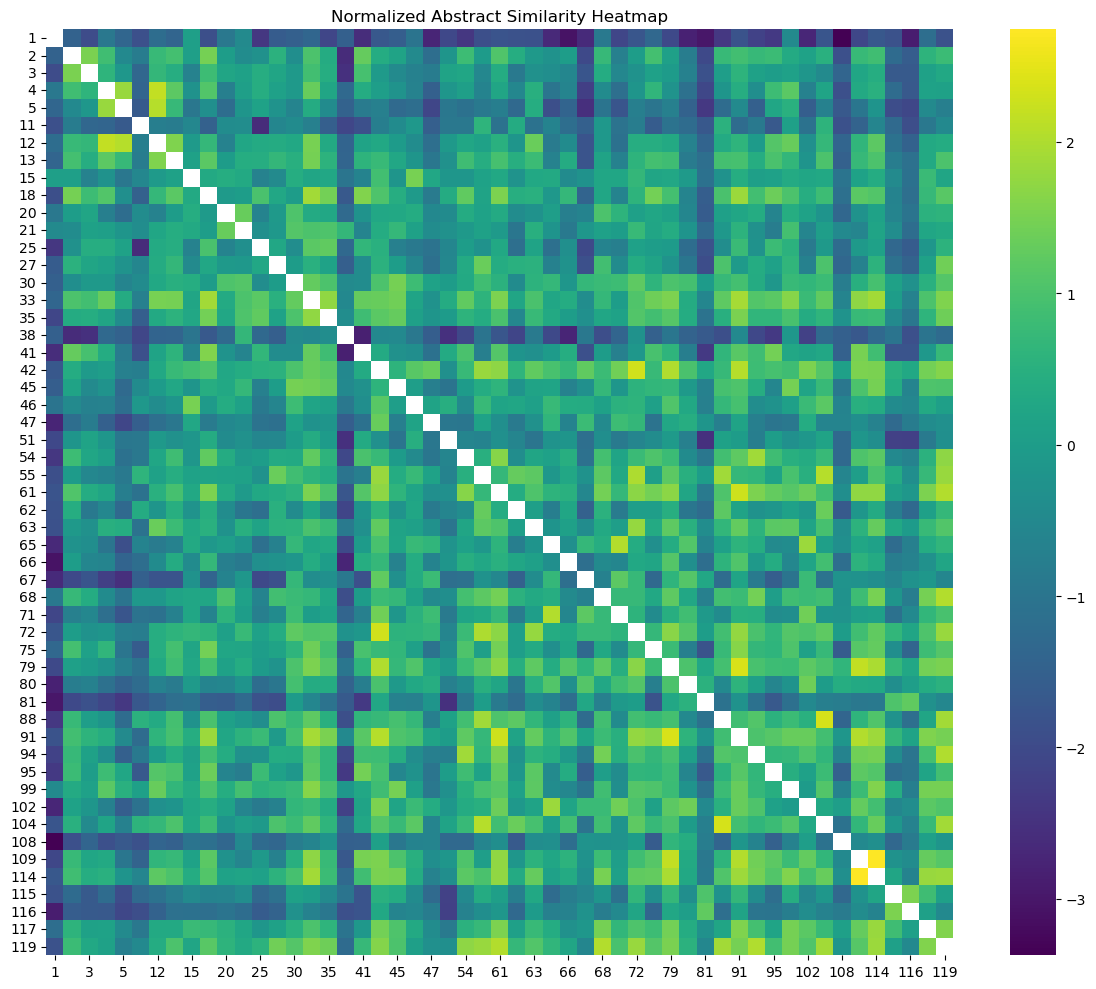

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create heatmap with normalized values
plt.figure(figsize=(12, 10))
sns.heatmap(normalized_similarity_df, cmap='viridis')
plt.title('Normalized Abstract Similarity Heatmap')
plt.tight_layout()
plt.show()

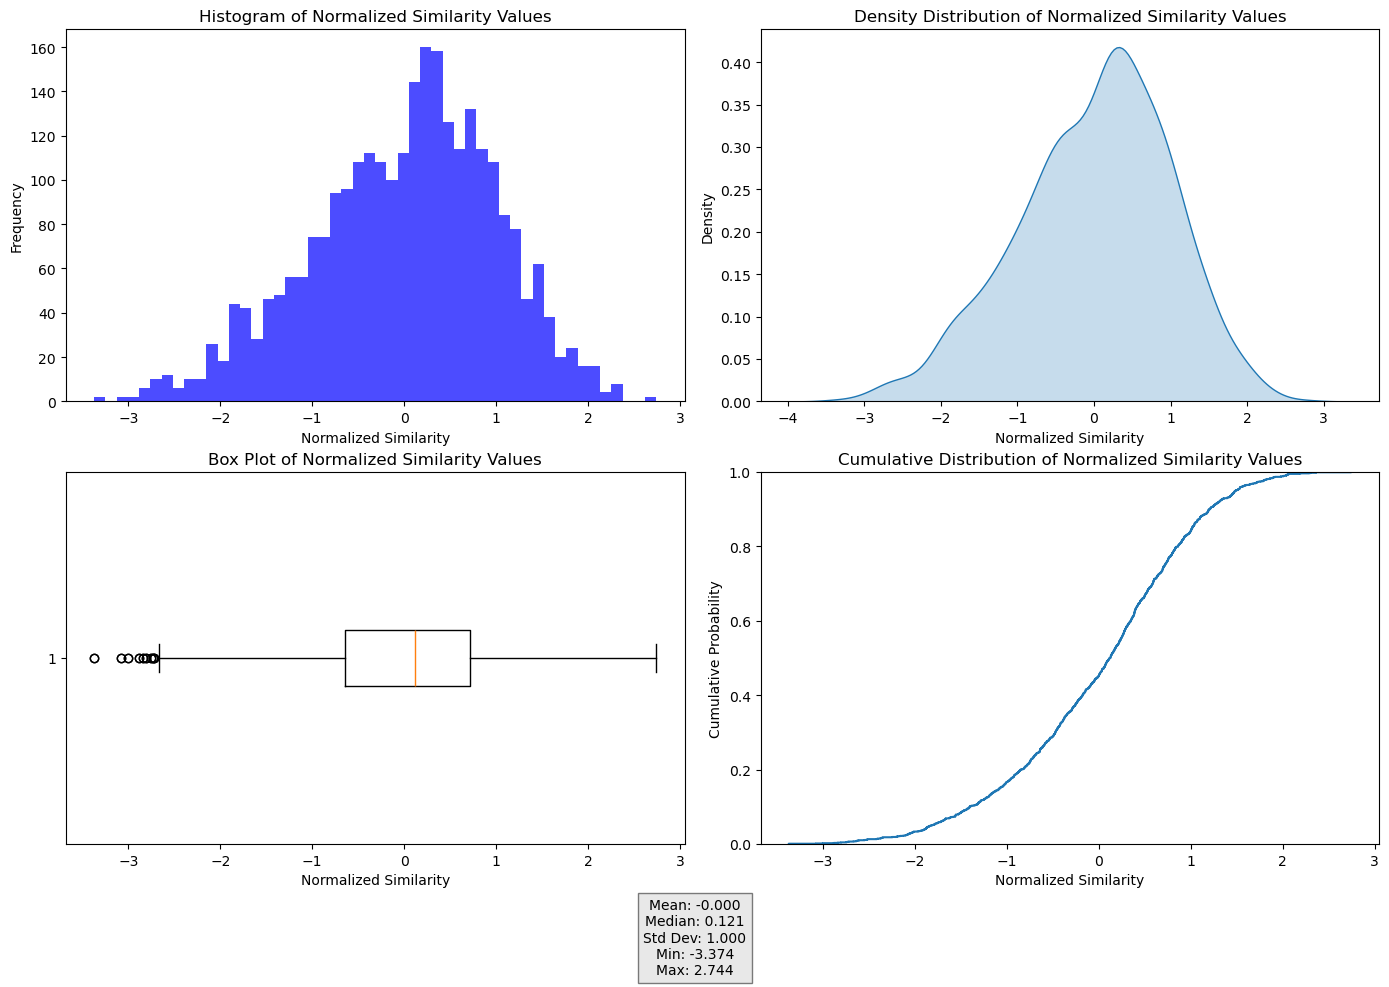

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Extract all values from the normalized matrix and flatten to 1D array
# No need to fill diagonal with NaN as it's already done
similarity_values = normalized_similarity_df.values
flat_similarities = similarity_values.flatten()
flat_similarities = flat_similarities[~np.isnan(flat_similarities)]  # Remove NaN values

# Create a figure with multiple visualization types
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Histogram
axes[0, 0].hist(flat_similarities, bins=50, alpha=0.7, color='blue')
axes[0, 0].set_title('Histogram of Normalized Similarity Values')
axes[0, 0].set_xlabel('Normalized Similarity')
axes[0, 0].set_ylabel('Frequency')

# 2. KDE (Kernel Density Estimation) plot
sns.kdeplot(flat_similarities, ax=axes[0, 1], fill=True)
axes[0, 1].set_title('Density Distribution of Normalized Similarity Values')
axes[0, 1].set_xlabel('Normalized Similarity')
axes[0, 1].set_ylabel('Density')

# 3. Box plot
axes[1, 0].boxplot(flat_similarities, vert=False)
axes[1, 0].set_title('Box Plot of Normalized Similarity Values')
axes[1, 0].set_xlabel('Normalized Similarity')

# 4. ECDF (Empirical Cumulative Distribution Function) plot
sns.ecdfplot(flat_similarities, ax=axes[1, 1])
axes[1, 1].set_title('Cumulative Distribution of Normalized Similarity Values')
axes[1, 1].set_xlabel('Normalized Similarity')
axes[1, 1].set_ylabel('Cumulative Probability')

# Add statistics text box
stats_text = (
    f"Mean: {flat_similarities.mean():.3f}\n"
    f"Median: {np.median(flat_similarities):.3f}\n"
    f"Std Dev: {flat_similarities.std():.3f}\n"
    f"Min: {flat_similarities.min():.3f}\n"
    f"Max: {flat_similarities.max():.3f}"
)
fig.text(0.5, 0.02, stats_text, ha='center', bbox=dict(facecolor='lightgray', alpha=0.5))

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Make room for text box
plt.show()